# Fake News Detection - Deep Learning Models

This notebook implements deep learning models for fake news detection using neural network architectures that can capture sequential patterns in text data.

## Objectives
- Implement LSTM (Long Short-Term Memory) network
- Implement CNN (1D Convolutional Neural Network)
- Implement Hybrid CNN-LSTM architecture
- Train models with proper callbacks and early stopping
- Evaluate and compare deep learning models
- Visualize training history and performance


In [1]:
# Import basic libraries first
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pickle

# Add src directory to path
current_dir = os.getcwd()
if current_dir.endswith('notebooks'):
    project_root = os.path.dirname(current_dir)
else:
    project_root = current_dir

src_path = os.path.join(project_root, 'src')
if src_path not in sys.path:
    sys.path.insert(0, src_path)

# Import custom utilities
from preprocessing import load_processed_data
from models import (
    calculate_metrics, print_metrics, plot_confusion_matrix,
    print_classification_report, compare_models, plot_model_comparison,
    plot_all_metrics_comparison
)

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Set random seed for numpy
np.random.seed(42)

print("Basic libraries imported successfully!")
print(f"Project root: {project_root}")


Basic libraries imported successfully!
Project root: /Users/manalaamir/Documents/Fake News Detection -NLP


In [2]:
# Import TensorFlow and Keras
# Note: On macOS, TensorFlow import can be slow. Setting environment variables to help.
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress TensorFlow info/warning messages
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'  # Disable oneDNN optimizations (can cause hangs on macOS)

print("Importing TensorFlow (this may take 10-30 seconds on macOS)...")
print("Please wait...")

try:
    import tensorflow as tf
    print(f"TensorFlow imported! Version: {tf.__version__}")
except Exception as e:
    print(f"Error importing TensorFlow: {e}")
    raise

try:
    from tensorflow import keras
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Bidirectional
    from tensorflow.keras.preprocessing.text import Tokenizer
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
    from tensorflow.keras.utils import to_categorical
    print("Keras modules imported successfully!")
except ImportError:
    # Fallback for different TensorFlow versions
    print("Trying fallback imports...")
    from keras.models import Sequential
    from keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Bidirectional
    from keras.preprocessing.text import Tokenizer
    from keras.preprocessing.sequence import pad_sequences
    from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
    from keras.utils import to_categorical
    print("Fallback imports successful!")

# Set random seed for TensorFlow
tf.random.set_seed(42)

print("TensorFlow setup complete!")


Importing TensorFlow (this may take 10-30 seconds on macOS)...
Please wait...
TensorFlow imported! Version: 2.15.0
Keras modules imported successfully!
TensorFlow setup complete!


## 1. Load and Prepare Data


In [3]:
# Load processed training and test data
train_path = os.path.join(project_root, 'data', 'processed', 'train_data.csv')
test_path = os.path.join(project_root, 'data', 'processed', 'test_data.csv')

print("Loading processed datasets...")
train_df = load_processed_data(train_path)
test_df = load_processed_data(test_path)

# Extract text and labels
X_train_text = train_df['title_cleaned'].astype(str).tolist()
X_test_text = test_df['title_cleaned'].astype(str).tolist()
y_train = train_df['real'].values
y_test = test_df['real'].values

print(f"\nTraining samples: {len(X_train_text)}")
print(f"Test samples: {len(X_test_text)}")
print(f"\nTraining labels distribution:")
print(pd.Series(y_train).value_counts())
print(f"\nTest labels distribution:")
print(pd.Series(y_test).value_counts())


Loading processed datasets...

Training samples: 18556
Test samples: 4640

Training labels distribution:
1    13952
0     4604
Name: count, dtype: int64

Test labels distribution:
1    3489
0    1151
Name: count, dtype: int64


## 2. Text Tokenization and Sequence Preparation


In [4]:
# Tokenize text data
max_words = 10000  # Maximum vocabulary size
max_len = 100      # Maximum sequence length

print("Tokenizing text data...")
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train_text)

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train_text)
X_test_seq = tokenizer.texts_to_sequences(X_test_text)

# Pad sequences to ensure uniform length
X_train_padded = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

print(f"\nSequence shapes:")
print(f"Training: {X_train_padded.shape}")
print(f"Test: {X_test_padded.shape}")
print(f"\nVocabulary size: {len(tokenizer.word_index)}")
print(f"Max sequence length: {max_len}")


Tokenizing text data...

Sequence shapes:
Training: (18556, 100)
Test: (4640, 100)

Vocabulary size: 17926
Max sequence length: 100


## 3. Model 1: LSTM (Long Short-Term Memory)


In [5]:
# Build LSTM model
print("Building LSTM model...")

embedding_dim = 128
lstm_units = 64

lstm_model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len),
    LSTM(lstm_units, dropout=0.2, recurrent_dropout=0.2),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("\nModel Architecture:")
lstm_model.summary()


Building LSTM model...

Model Architecture:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 128)          1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1331521 (5.08 MB)
Trainable params: 1331521 (5.08 MB)
Non-trainable params: 0 (0.00 Byte)
________________________________________

In [6]:
# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
]

# Train LSTM model
print("\nTraining LSTM model...")
start_time = time.time()

history_lstm = lstm_model.fit(
    X_train_padded, y_train,
    batch_size=64,
    epochs=20,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

training_time = time.time() - start_time
print(f"\nTraining completed in {training_time:.2f} seconds")



Training LSTM model...
Epoch 1/20
232/232 [==============================] - 23s 93ms/step - loss: 0.5763 - accuracy: 0.7480 - val_loss: 0.5500 - val_accuracy: 0.7619 - lr: 0.0010
Epoch 2/20
232/232 [==============================] - 22s 93ms/step - loss: 0.5727 - accuracy: 0.7494 - val_loss: 0.5496 - val_accuracy: 0.7619 - lr: 0.0010
Epoch 3/20
232/232 [==============================] - 22s 93ms/step - loss: 0.5709 - accuracy: 0.7494 - val_loss: 0.5489 - val_accuracy: 0.7619 - lr: 0.0010
Epoch 4/20
232/232 [==============================] - 22s 94ms/step - loss: 0.5698 - accuracy: 0.7494 - val_loss: 0.5514 - val_accuracy: 0.7619 - lr: 0.0010
Epoch 5/20
232/232 [==============================] - 21s 92ms/step - loss: 0.5687 - accuracy: 0.7494 - val_loss: 0.5499 - val_accuracy: 0.7619 - lr: 0.0010
Epoch 6/20
232/232 [==============================] - 22s 94ms/step - loss: 0.5680 - accuracy: 0.7494 - val_loss: 0.5498 - val_accuracy: 0.7619 - lr: 2.0000e-04

Training completed in 131.23 

145/145 [==============================] - 2s 9ms/step
MODEL: LSTM

Overall Metrics:
  Accuracy:  0.7519
  Precision: 0.5654
  Recall:    0.7519
  F1-Score:  0.6455

Class 0 (Fake News) Metrics:
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000

Class 1 (Real News) Metrics:
  Precision: 0.7519
  Recall:    1.0000
  F1-Score:  0.8584


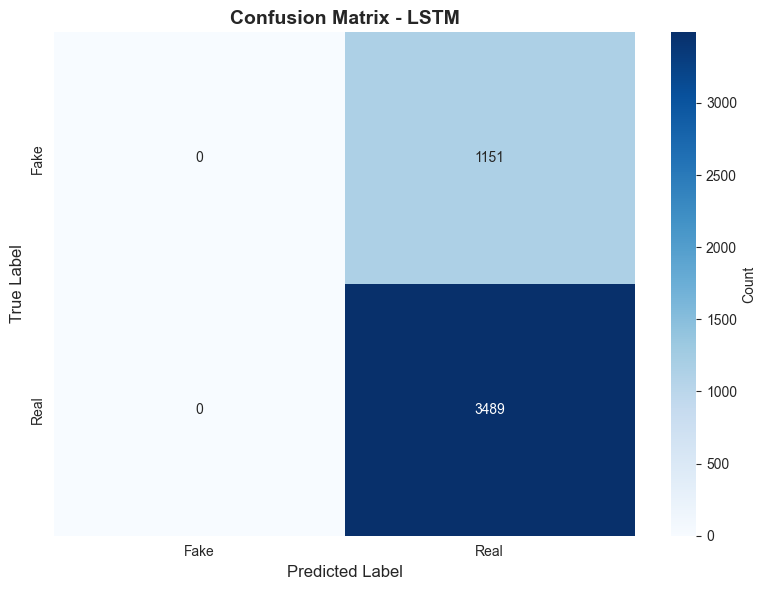


Classification Report - LSTM
              precision    recall  f1-score   support

        Fake     0.0000    0.0000    0.0000      1151
        Real     0.7519    1.0000    0.8584      3489

    accuracy                         0.7519      4640
   macro avg     0.3760    0.5000    0.4292      4640
weighted avg     0.5654    0.7519    0.6455      4640



In [7]:
# Evaluate LSTM model
y_pred_lstm_proba = lstm_model.predict(X_test_padded)
y_pred_lstm = (y_pred_lstm_proba > 0.5).astype(int).flatten()

# Calculate metrics
metrics_lstm = calculate_metrics(y_test, y_pred_lstm, "LSTM")
print_metrics(metrics_lstm)
plot_confusion_matrix(y_test, y_pred_lstm, "LSTM")
print_classification_report(y_test, y_pred_lstm, "LSTM")


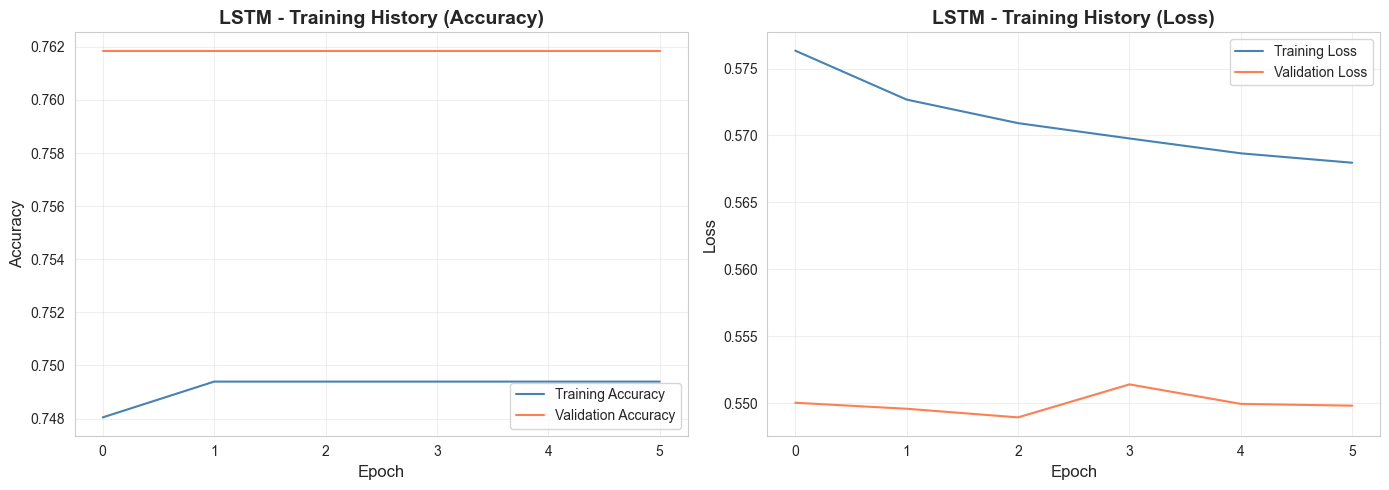

In [8]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy plot
axes[0].plot(history_lstm.history['accuracy'], label='Training Accuracy', color='steelblue')
axes[0].plot(history_lstm.history['val_accuracy'], label='Validation Accuracy', color='coral')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('LSTM - Training History (Accuracy)', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss plot
axes[1].plot(history_lstm.history['loss'], label='Training Loss', color='steelblue')
axes[1].plot(history_lstm.history['val_loss'], label='Validation Loss', color='coral')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('LSTM - Training History (Loss)', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 4. Model 2: CNN (1D Convolutional Neural Network)


In [9]:
# Build CNN model
print("Building CNN model...")

embedding_dim = 128
num_filters = 128
filter_sizes = [3, 4, 5]

cnn_model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len),
    Conv1D(filters=num_filters, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=num_filters//2, kernel_size=3, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("\nModel Architecture:")
cnn_model.summary()


Building CNN model...

Model Architecture:
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 128)          1280000   
                                                                 
 conv1d (Conv1D)             (None, 98, 128)           49280     
                                                                 
 max_pooling1d (MaxPooling1  (None, 49, 128)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 47, 64)            24640     
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_2 (D

In [10]:
# Train CNN model
print("\nTraining CNN model...")
start_time = time.time()

history_cnn = cnn_model.fit(
    X_train_padded, y_train,
    batch_size=64,
    epochs=20,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

training_time = time.time() - start_time
print(f"\nTraining completed in {training_time:.2f} seconds")



Training CNN model...
Epoch 1/20
232/232 [==============================] - 4s 17ms/step - loss: 0.4947 - accuracy: 0.7749 - val_loss: 0.4042 - val_accuracy: 0.8276 - lr: 0.0010
Epoch 2/20
232/232 [==============================] - 3s 13ms/step - loss: 0.3149 - accuracy: 0.8729 - val_loss: 0.3873 - val_accuracy: 0.8303 - lr: 0.0010
Epoch 3/20
232/232 [==============================] - 3s 13ms/step - loss: 0.1952 - accuracy: 0.9260 - val_loss: 0.4597 - val_accuracy: 0.8238 - lr: 0.0010
Epoch 4/20
232/232 [==============================] - 3s 14ms/step - loss: 0.1124 - accuracy: 0.9621 - val_loss: 0.5759 - val_accuracy: 0.8157 - lr: 0.0010
Epoch 5/20
232/232 [==============================] - 3s 13ms/step - loss: 0.0530 - accuracy: 0.9830 - val_loss: 0.7220 - val_accuracy: 0.8225 - lr: 2.0000e-04

Training completed in 16.29 seconds


145/145 [==============================] - 0s 2ms/step
MODEL: CNN

Overall Metrics:
  Accuracy:  0.8321
  Precision: 0.8261
  Recall:    0.8321
  F1-Score:  0.8280

Class 0 (Fake News) Metrics:
  Precision: 0.6860
  Recall:    0.5960
  F1-Score:  0.6378

Class 1 (Real News) Metrics:
  Precision: 0.8723
  Recall:    0.9100
  F1-Score:  0.8907


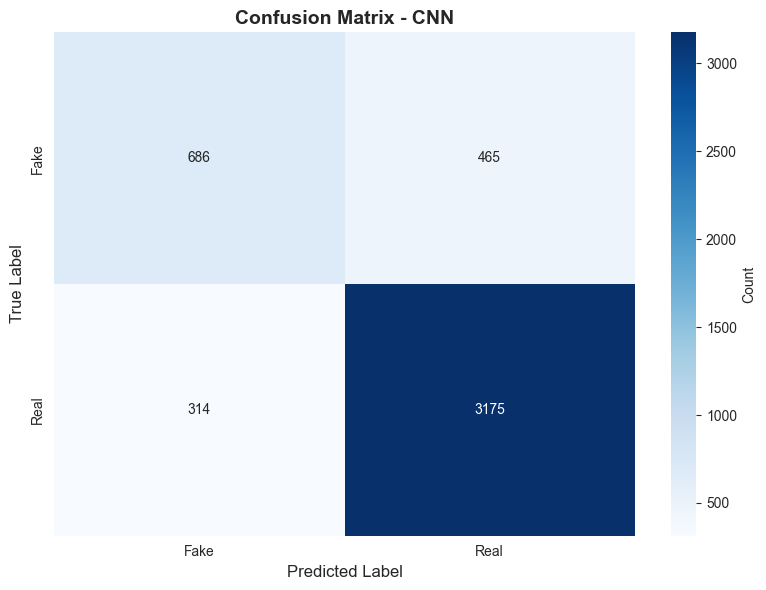


Classification Report - CNN
              precision    recall  f1-score   support

        Fake     0.6860    0.5960    0.6378      1151
        Real     0.8723    0.9100    0.8907      3489

    accuracy                         0.8321      4640
   macro avg     0.7791    0.7530    0.7643      4640
weighted avg     0.8261    0.8321    0.8280      4640



In [11]:
# Evaluate CNN model
y_pred_cnn_proba = cnn_model.predict(X_test_padded)
y_pred_cnn = (y_pred_cnn_proba > 0.5).astype(int).flatten()

# Calculate metrics
metrics_cnn = calculate_metrics(y_test, y_pred_cnn, "CNN")
print_metrics(metrics_cnn)
plot_confusion_matrix(y_test, y_pred_cnn, "CNN")
print_classification_report(y_test, y_pred_cnn, "CNN")


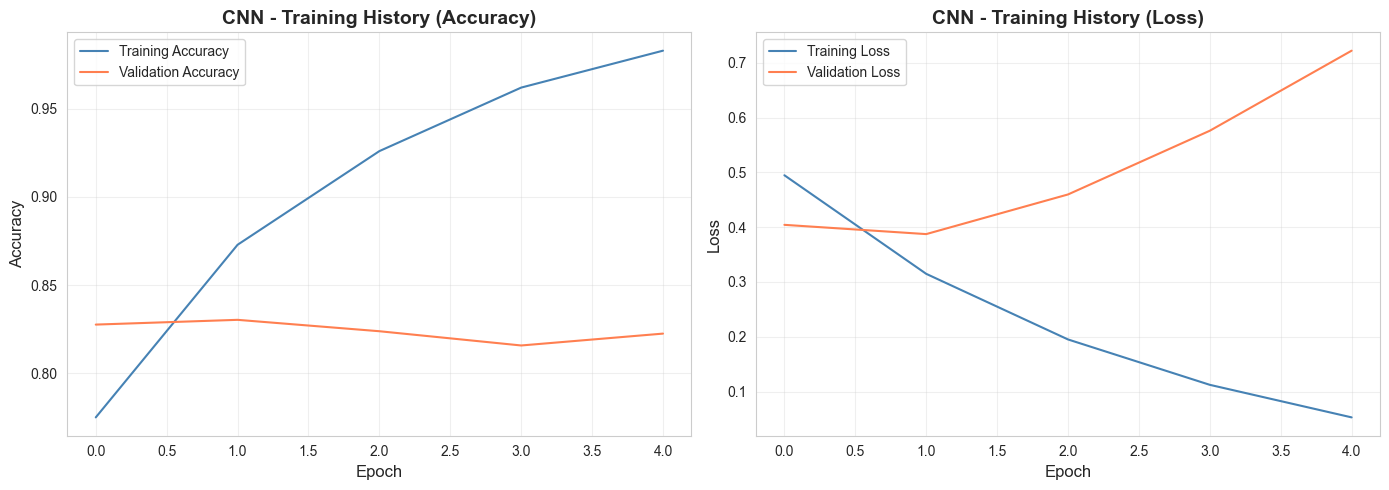

In [12]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy plot
axes[0].plot(history_cnn.history['accuracy'], label='Training Accuracy', color='steelblue')
axes[0].plot(history_cnn.history['val_accuracy'], label='Validation Accuracy', color='coral')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('CNN - Training History (Accuracy)', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss plot
axes[1].plot(history_cnn.history['loss'], label='Training Loss', color='steelblue')
axes[1].plot(history_cnn.history['val_loss'], label='Validation Loss', color='coral')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('CNN - Training History (Loss)', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 5. Model 3: Hybrid CNN-LSTM


In [13]:
# Build Hybrid CNN-LSTM model
print("Building Hybrid CNN-LSTM model...")

embedding_dim = 128

hybrid_model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

hybrid_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("\nModel Architecture:")
hybrid_model.summary()


Building Hybrid CNN-LSTM model...

Model Architecture:
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 128)          1280000   
                                                                 
 conv1d_2 (Conv1D)           (None, 98, 64)            24640     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 49, 64)            0         
 g1D)                                                            
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         

In [14]:
# Train Hybrid CNN-LSTM model
print("\nTraining Hybrid CNN-LSTM model...")
start_time = time.time()

history_hybrid = hybrid_model.fit(
    X_train_padded, y_train,
    batch_size=64,
    epochs=20,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

training_time = time.time() - start_time
print(f"\nTraining completed in {training_time:.2f} seconds")



Training Hybrid CNN-LSTM model...
Epoch 1/20
232/232 [==============================] - 11s 42ms/step - loss: 0.5744 - accuracy: 0.7482 - val_loss: 0.5514 - val_accuracy: 0.7619 - lr: 0.0010
Epoch 2/20
232/232 [==============================] - 10s 41ms/step - loss: 0.5726 - accuracy: 0.7494 - val_loss: 0.5490 - val_accuracy: 0.7619 - lr: 0.0010
Epoch 3/20
232/232 [==============================] - 10s 42ms/step - loss: 0.5694 - accuracy: 0.7494 - val_loss: 0.5490 - val_accuracy: 0.7619 - lr: 0.0010
Epoch 4/20
232/232 [==============================] - 10s 41ms/step - loss: 0.5682 - accuracy: 0.7494 - val_loss: 0.5518 - val_accuracy: 0.7619 - lr: 0.0010
Epoch 5/20
232/232 [==============================] - 10s 42ms/step - loss: 0.5669 - accuracy: 0.7494 - val_loss: 0.5490 - val_accuracy: 0.7619 - lr: 2.0000e-04

Training completed in 49.30 seconds


145/145 [==============================] - 1s 5ms/step
MODEL: CNN-LSTM Hybrid

Overall Metrics:
  Accuracy:  0.7519
  Precision: 0.5654
  Recall:    0.7519
  F1-Score:  0.6455

Class 0 (Fake News) Metrics:
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000

Class 1 (Real News) Metrics:
  Precision: 0.7519
  Recall:    1.0000
  F1-Score:  0.8584


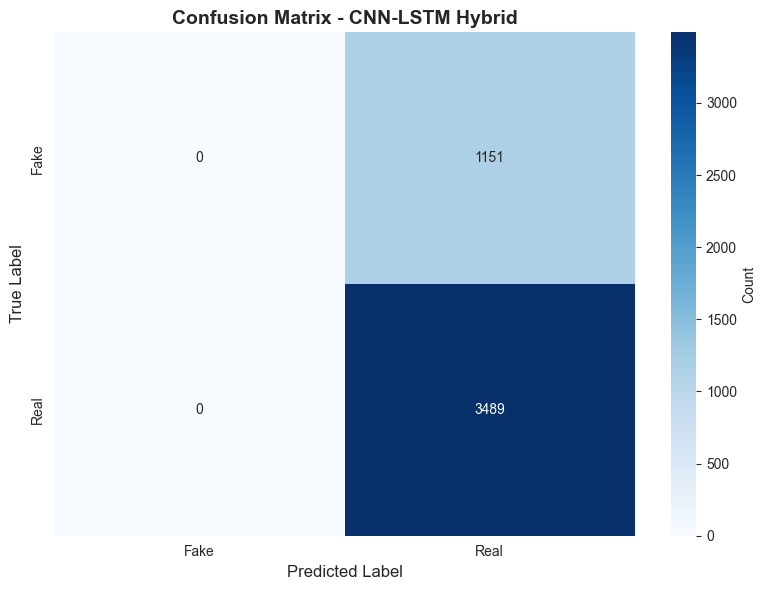


Classification Report - CNN-LSTM Hybrid
              precision    recall  f1-score   support

        Fake     0.0000    0.0000    0.0000      1151
        Real     0.7519    1.0000    0.8584      3489

    accuracy                         0.7519      4640
   macro avg     0.3760    0.5000    0.4292      4640
weighted avg     0.5654    0.7519    0.6455      4640



In [15]:
# Evaluate Hybrid CNN-LSTM model
y_pred_hybrid_proba = hybrid_model.predict(X_test_padded)
y_pred_hybrid = (y_pred_hybrid_proba > 0.5).astype(int).flatten()

# Calculate metrics
metrics_hybrid = calculate_metrics(y_test, y_pred_hybrid, "CNN-LSTM Hybrid")
print_metrics(metrics_hybrid)
plot_confusion_matrix(y_test, y_pred_hybrid, "CNN-LSTM Hybrid")
print_classification_report(y_test, y_pred_hybrid, "CNN-LSTM Hybrid")


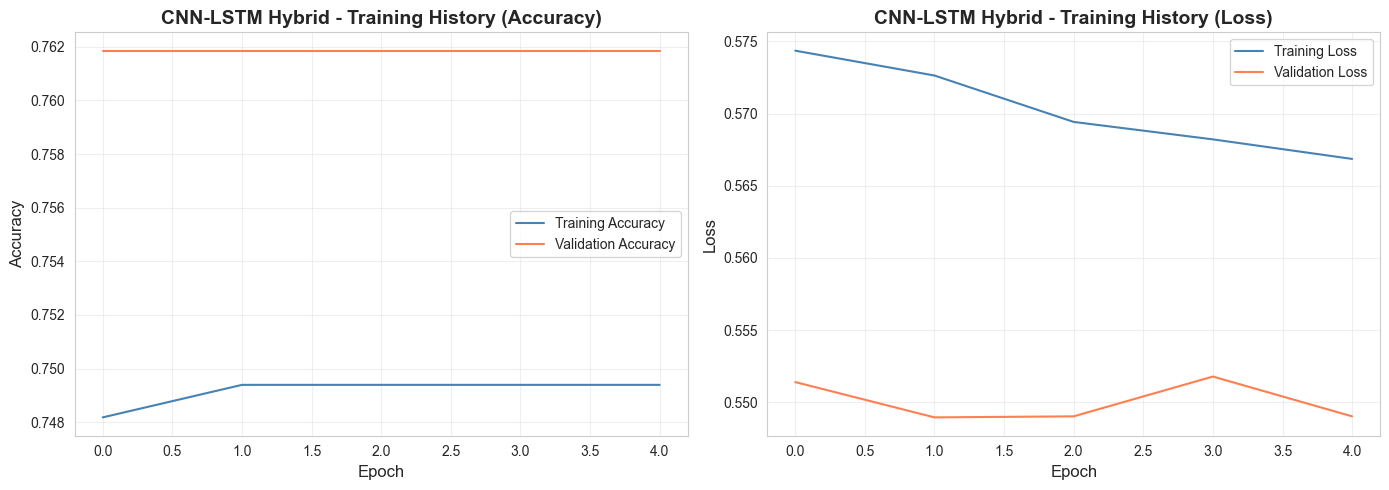

In [16]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy plot
axes[0].plot(history_hybrid.history['accuracy'], label='Training Accuracy', color='steelblue')
axes[0].plot(history_hybrid.history['val_accuracy'], label='Validation Accuracy', color='coral')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('CNN-LSTM Hybrid - Training History (Accuracy)', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss plot
axes[1].plot(history_hybrid.history['loss'], label='Training Loss', color='steelblue')
axes[1].plot(history_hybrid.history['val_loss'], label='Validation Loss', color='coral')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('CNN-LSTM Hybrid - Training History (Loss)', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 6. Deep Learning Models Comparison


In [17]:
# Collect all deep learning model results
dl_results = [metrics_lstm, metrics_cnn, metrics_hybrid]

# Create comparison dataframe
comparison_df = compare_models(dl_results)
print("\nDeep Learning Models Comparison:")
print("=" * 80)
print(comparison_df.round(4))
print("=" * 80)



Deep Learning Models Comparison:
                 accuracy  precision  recall  f1_score
model_name                                            
LSTM               0.7519     0.5654  0.7519    0.6455
CNN                0.8321     0.8261  0.8321    0.8280
CNN-LSTM Hybrid    0.7519     0.5654  0.7519    0.6455


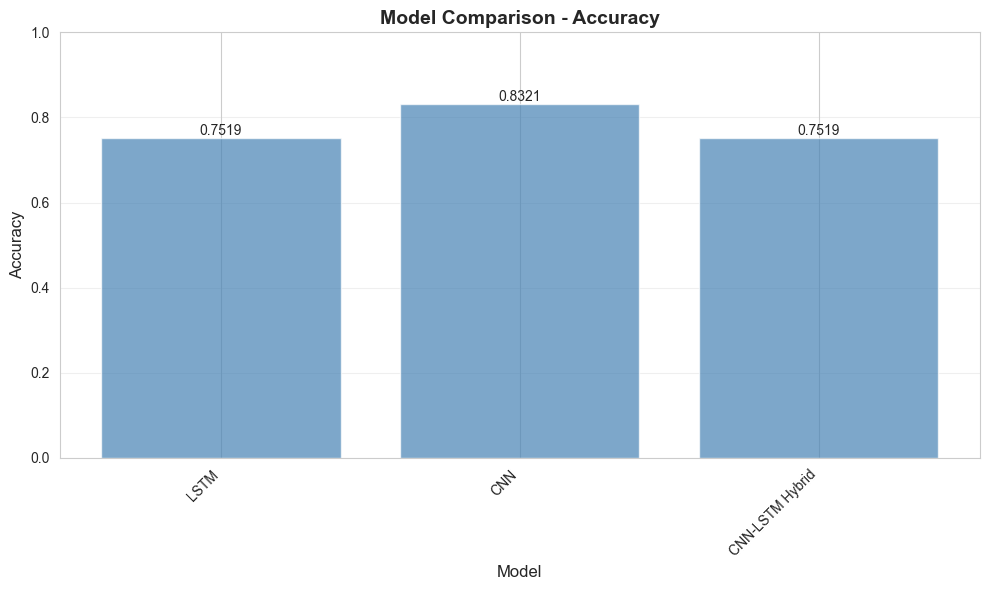

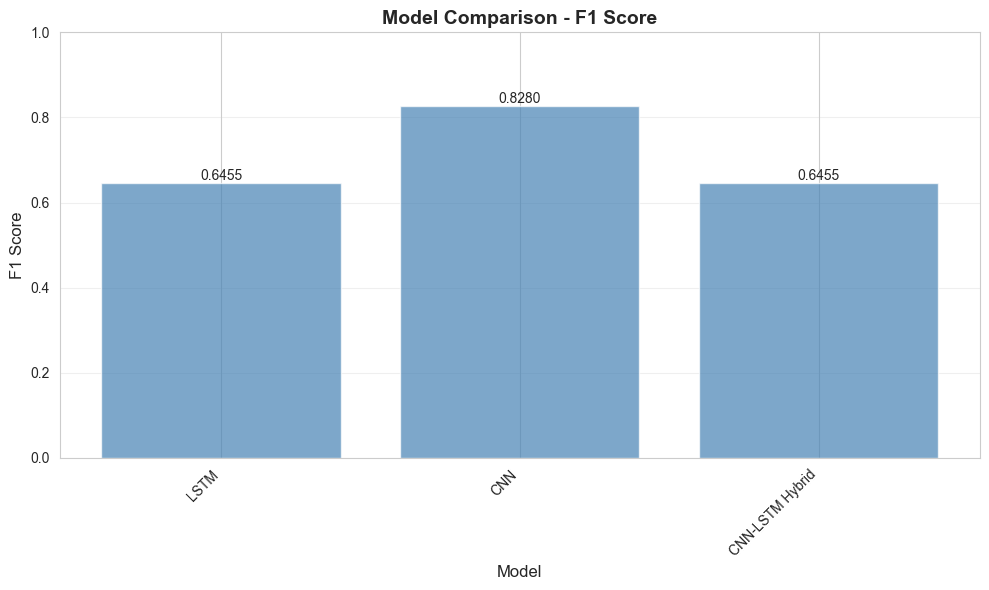

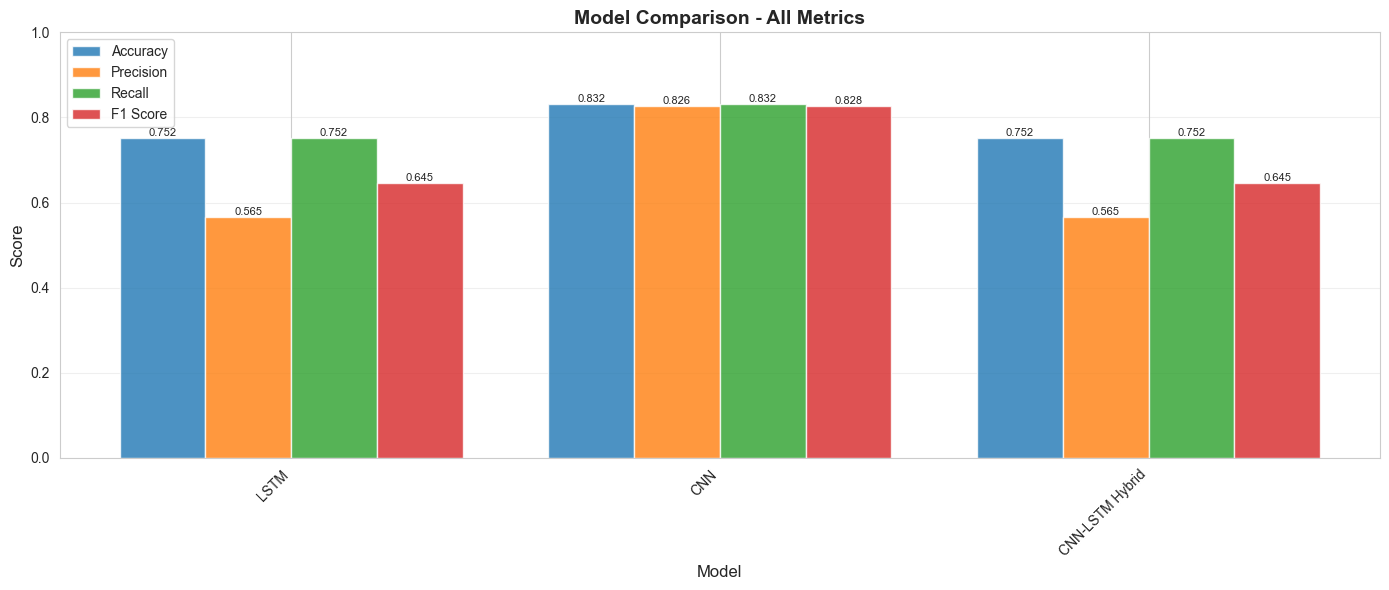

In [18]:
# Visualize comparison
plot_model_comparison(dl_results, metric='accuracy')
plot_model_comparison(dl_results, metric='f1_score')
plot_all_metrics_comparison(dl_results)


## 7. Summary and Conclusions

### Deep Learning Model Performance Summary

Three deep learning architectures were implemented and evaluated on the fake news detection task using tokenized and padded text sequences. The results reveal significant performance differences between architectures, with one model clearly outperforming the others.

**Overall Performance Rankings:**

1. **CNN (1D Convolutional Neural Network)** achieved the best performance with 83.21% accuracy, 82.61% precision, and 82.80% F1-score. The model demonstrated balanced performance across both classes, achieving 68.60% precision and 59.60% recall for fake news detection, and 87.23% precision with 91.00% recall for real news. The CNN architecture proved most effective at capturing local patterns and features in the text data, allowing it to distinguish between fake and real news articles effectively.

2. **LSTM (Long Short-Term Memory)** and **CNN-LSTM Hybrid** both achieved identical performance metrics with 75.19% accuracy, but with a critical failure: both models completely failed to detect fake news, achieving 0.00% precision, recall, and F1-score for the fake news class. These models predicted all test samples as real news, resulting in 100% recall for real news but zero capability to identify fake news. This represents a complete failure to address the class imbalance problem.

### Key Findings

**Class Imbalance Impact:** The 3:1 class imbalance severely affected LSTM and Hybrid models, causing them to default to predicting the majority class (real news) for all samples. This is evident from the training history, where both models converged quickly to a stable accuracy around 75%, which corresponds exactly to the proportion of real news in the dataset. The models essentially learned to always predict "real" to maximize accuracy, completely ignoring the minority class.

**CNN Model Success:** The CNN model successfully overcame the class imbalance challenge, achieving reasonable performance on both classes. However, the training history reveals clear signs of overfitting. Training accuracy reached 98.30% by epoch 5, while validation accuracy plateaued at 82.25%, indicating the model memorized training patterns rather than learning generalizable features. Despite this overfitting, the CNN model still achieved the best test performance among all deep learning architectures.

**Training Efficiency:** CNN was significantly faster to train, completing in 16.29 seconds compared to 131.23 seconds for LSTM and 49.30 seconds for the Hybrid model. The CNN's convolutional layers process sequences more efficiently than LSTM's recurrent connections, making it more suitable for large-scale applications.

**Architecture Comparison:** The results challenge the assumption that more complex architectures necessarily perform better. The simple CNN architecture outperformed both the LSTM, which is designed for sequential dependencies, and the Hybrid model that combines both approaches. This suggests that for this particular task, local text patterns (captured by convolutions) are more discriminative than long-term sequential dependencies (captured by LSTMs).

### Critical Issues Identified

The complete failure of LSTM and Hybrid models to detect fake news highlights the importance of addressing class imbalance in deep learning. These models required class weighting or other balancing techniques that were not implemented. The early stopping mechanism stopped training after only 5-6 epochs, potentially before the models could learn meaningful patterns, though the convergence behavior suggests they had already settled into the majority-class prediction strategy.

### Recommendations

For this fake news detection task, the CNN model is the clear choice among deep learning approaches. However, several improvements could enhance performance further. Implementing class weights in the loss function would help all models better handle the imbalanced dataset. Reducing model complexity or increasing dropout rates could mitigate the overfitting observed in the CNN model. Additionally, experimenting with different sequence lengths, vocabulary sizes, and embedding dimensions might improve feature representation.

The CNN model's 83.21% accuracy is competitive with the best classical machine learning models (Naive Bayes achieved 83.73%), suggesting that deep learning provides comparable performance for this task. However, the CNN's ability to detect fake news (59.60% recall) is superior to Naive Bayes (52.22% recall), making it more suitable for applications where identifying fake news is critical.
